<a href="https://colab.research.google.com/github/fastai-energetic-engineering/ashrae/blob/master/ASHRAE_energy_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASHRAE Energy Prediction

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastai, kaggle]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: false


In [1]:
#collapse
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 32.0MB/s 
     |████████████████████████████████| 1.2MB 48.2MB/s 
     |████████████████████████████████| 194kB 52.8MB/s 
     |████████████████████████████████| 51kB 9.8MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 61kB 11.5MB/s 
Mounted at /content/gdrive


In [2]:
#collapse
#from fastbook import *
import os
#from google.colab import files
import pandas as pd
import datetime as dt

from fastai.tabular.all import *


In [3]:
# Load ASHRAE energy dataset from your google drive
p = 'gdrive/MyDrive/Colab Notebooks/ashrae'
os.chdir(p)

## Joining Tables

Our training data comprised of three tables:
- `building_metadata.csv`
- `weather_train.csv`
- `train.csv`

We need to join the tables. First, let's see what's in the tables.

In [4]:
building = pd.read_csv('data/building_metadata.csv')
weather = pd.read_csv('data/weather_train.csv')
train = pd.read_csv('data/train.csv')

`building` contains the buildings' metadata.

In [5]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


- `site_id` - Foreign key for the weather files.
- `building_id` - Foreign key for training.csv
- `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
- `square_feet` - Gross floor area of the building
- `year_built` - Year building was opened
- `floor_count` - Number of floors of the building

`weather` contains weather data from the closest meteorological station.

In [6]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


- `site_id`
- `air_temperature` - Degrees Celsius
- `cloud_coverage` - Portion of the sky covered in clouds, in oktas
- `dew_temperature` - Degrees Celsius
- `precip_depth_1_hr` - Millimeters
- `sea_level_pressure` - Millibar/hectopascals
- `wind_direction` - Compass direction (0-360)
- `wind_speed` - Meters per second

Finally, `train` contains the target variable, `meter reading`, which represents energy consumption in kWh.

In [7]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


- `building_id` - Foreign key for the building metadata.
- `meter` - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
- `timestamp` - When the measurement was taken
- `meter_reading` - The target variable. Energy consumption in kWh (or equivalent).

Apparently there was some issues regarding the timestamps, as noted by [this post](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115040#latest-667889). The timestamp in the weather and meter reading table were in GMT and local time, respectively. We have to keep this in mind before merging the tables.

Here I wrote a function that can prepare train and test data accordingly.

In [8]:
def prepare_data(type='train'):
    assert type in ['train', 'test']
    
    # read data
    building = pd.read_csv('data/building_metadata.csv')
    weather = pd.read_csv(f'data/weather_{type}.csv')
    data = pd.read_csv(f'data/{type}.csv')

    # convert datetime
    data['timestamp'] = pd.to_datetime(data['timestamp'])

    # adjust timestamp
    timediff = {0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4}
    weather['time_diff']= weather['site_id'].map(timediff)
    weather['time_diff'] = weather['time_diff'].apply(lambda x: dt.timedelta(hours=x))
    weather['timestamp_gmt'] = pd.to_datetime(weather['timestamp'])
    weather['timestamp'] = weather['timestamp_gmt'] - weather['time_diff']

    # merge table
    data = data.merge(building, on='building_id', how='left')
    data = data.merge(weather, on=['site_id','timestamp'], how='left')

    return data

Let's try this function out!

In [9]:
train = prepare_data('train')
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,time_diff,timestamp_gmt
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,0 days 04:00:00,2016-01-01 04:00:00
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,0 days 04:00:00,2016-01-01 04:00:00
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,0 days 04:00:00,2016-01-01 04:00:00
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,0 days 04:00:00,2016-01-01 04:00:00
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,0 days 04:00:00,2016-01-01 04:00:00


In [10]:
# Engineer a feature
train['hour'] = train.timestamp.dt.hour

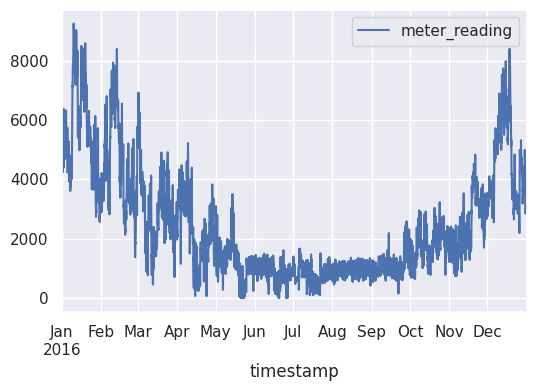

In [11]:
# Get a subset of the data, just one building and meter

train_only1 = train[(train['building_id']==1126) & (train['meter']==2)]
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100
sns.set()
#%matplotlib inlinefig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
train_only1[['timestamp', 'meter_reading']].set_index('timestamp').plot()


In [12]:
# Use an splitter and load using TabularPandas then to a dataloader

# Drop rows with any column N/A, rather than FillMissing
#train_good = train_only1[['timestamp', 'building_id', 'meter_reading', 'meter', 'air_temperature', 'dew_temperature', 'hour']].dropna()
train_good = train_only1[['timestamp', 'building_id', 'meter_reading', 'meter', 'air_temperature', 'dew_temperature', 'hour']].dropna()

# 2-fold cross-validation. Build 2 models, each with half the year as training data
splits1=MaskSplitter(train_good['timestamp'] < '2016-07-01')(range_of(train_good))
to1 = TabularPandas(train_good, procs=[Categorify],#, FillMissing, Normalize],
                   cat_names = [],#'building_id', 'meter'],
                   cont_names = ['air_temperature', 'hour', 'dew_temperature'],
                   y_names='meter_reading',
                   splits=splits1)
dls1 = to1.dataloaders(bs=64)

Load entire dataset or subset:

In [ ]:
#@title
# Load the entire dataset into a TabularDataLoader

cat_names = ['building_id', 'meter', 'site_id', 'primary_use']
#cont_names = ['timestamp', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'time_diff', 'timestamp_gmt']
cont_names = ['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(train.head(64*64), procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="meter_reading")

In [ ]:
#@title
# Load a smaller dataset into a TabularDataLoader

t = train[['meter_reading','building_id','meter','air_temperature']]
from fastai.tabular.all import *
cat_names = ['building_id','meter']
cont_names = ['air_temperature']
procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(t.head(64*1000), procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="meter_reading")

In [ ]:
dls1.show_batch()

In [13]:
# Train a model

learn = tabular_learner(dls1, metrics=rmse)
learn.summary()
# Exploring the learning rates
#learn.lr_find(stop_div=False)
learn.fit_one_cycle(10, lr_max=1e-1)

epoch,train_loss,valid_loss,_rmse,time
0,5723031.000000,10701905.000000,3271.376221,00:01
1,1922800.875000,218832.578125,467.795380,00:00
2,568898.375000,560960.000000,748.972717,00:00
3,270429.500000,165706.687500,407.070831,00:00
4,190709.390625,323686.062500,568.934143,00:00
5,168533.187500,204524.859375,452.244293,00:00
6,134075.187500,251868.796875,501.865326,00:00
7,137421.359375,167953.265625,409.820984,00:00
8,132871.390625,196285.453125,443.041077,00:00
9,153221.578125,198916.843750,446.000977,00:00


,air_temperature,hour,dew_temperature,meter_reading,meter_reading_pred
0,19.400000,5.0,13.900000,892.578003,883.938965
1,-15.000000,11.0,-18.299999,7209.229980,6522.796387
2,18.900000,15.0,15.600000,969.726990,1170.851929
3,7.800000,4.0,3.300000,1739.260010,1934.708740
4,-16.700001,19.0,-21.700001,7597.169922,6691.621094
5,5.000000,16.0,-11.100000,2978.520020,2899.880859
6,2.200000,0.0,-1.700000,3055.659912,2726.584717
7,-7.800000,11.0,-9.400000,5567.379883,5250.695312
8,-6.100000,6.0,-8.900000,3603.030029,4687.701172


Training set R2: 0.976709267760234 RMSE: 234.79373
Validation set R2: 0.9360060667332117 RMSE: 446.00098


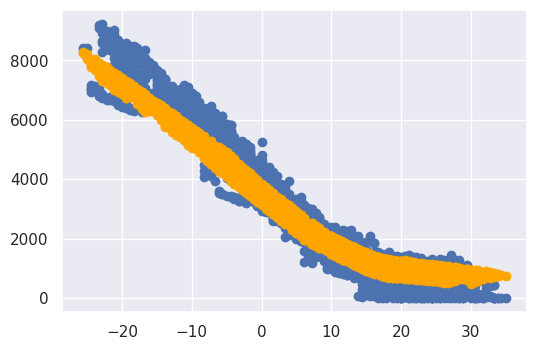

In [14]:
learn.show_results()
from sklearn.metrics import mean_squared_error, r2_score

xs,y = to1.train.xs,to1.train.y
valid_xs,valid_y = to1.valid.xs,to1.valid.y

y_pred,y_targs = learn.get_preds(ds_idx=0)
valid_y_pred,valid_y_targs = learn.get_preds()

print("Training set R2: " + str(r2_score(y_pred.detach().numpy(), y)) + " RMSE: " + str(mean_squared_error(y_pred.detach().numpy(), y, squared=False)))
print("Validation set R2: " + str(r2_score(valid_y_pred.detach().numpy(), valid_y)) + " RMSE: " + str(mean_squared_error(valid_y_pred.detach().numpy(), valid_y, squared=False)))

plt.scatter(valid_xs['air_temperature'], valid_y)
plt.scatter(valid_xs['air_temperature'], valid_y_pred.detach().numpy(), color='orange')

In [ ]:
y_targs.shape

torch.Size([4410, 1])

Training set R2: 0.8810366827535325 RMSE: 535.787
Validation set R2: 0.848515958335037 RMSE: 797.66364
Coefficients: [-76.61646    9.858627 -53.293335]
Intercept: 3165.656


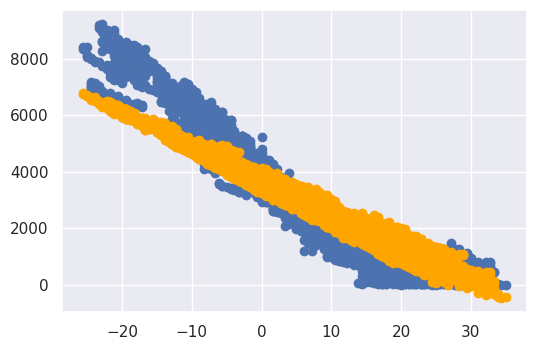

In [ ]:
# Linear regression using scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

xs,y = to1.train.xs,to1.train.y
valid_xs,valid_y = to1.valid.xs,to1.valid.y
m = LinearRegression()
m.fit(xs.to_numpy(), y);
print("Training set R2: " + str(m.score(xs, y)) + " RMSE: " + str(mean_squared_error(y, m.predict(xs), squared=False)))
print("Validation set R2: " + str(m.score(valid_xs, valid_y)) + " RMSE: " + str(mean_squared_error(valid_y, m.predict(valid_xs), squared=False)))
print("Coefficients: " + str(m.coef_))
print("Intercept: " + str(m.intercept_))

#plt.scatter(xs['air_temperature'],y)
plt.scatter(valid_xs['air_temperature'], valid_y)
plt.scatter(valid_xs['air_temperature'], m.predict(valid_xs),color='orange')

Note that the scattered orange line above is due to multiple input variables yet we're just plotting against air_temperature. When just using one input variable, the line is straight.

Parameter containing:
tensor([[-0.0279, -0.2112, -0.4328]], requires_grad=True)
Parameter containing:
tensor([0.3425], requires_grad=True)
tensor(6083564.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(3157270.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(3038562.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(3040172.5000, grad_fn=<MseLossBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Using a target size (torch.Size([4410])) that is different to the input size (torch.Size([4410, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Using a target size (torch.Size([58])) that is different to the input size (torch.Size([58, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Using a target size (torch.Size([4410])) that is different to the input size (tor

Training loss:  tensor(3001640., grad_fn=<MseLossBackward>)
Training loss:  tensor(2953377.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2978136.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2934418.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2877487.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2840216., grad_fn=<MseLossBackward>)
Training loss:  tensor(2837932.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2799506.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2836210.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2776785.7500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2802382., grad_fn=<MseLossBackward>)
Training loss:  tensor(2742863., grad_fn=<MseLossBackward>)
Training loss:  tensor(2720460.7500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2746403.7500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2706342.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2714497.5000, grad_fn=<MseLossBac

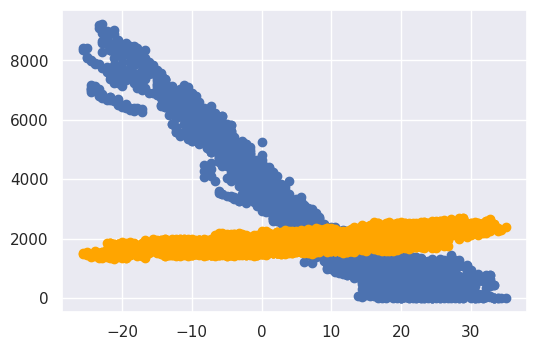

In [ ]:
# Linear regression using PyTorch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

xs,y = torch.tensor(to1.train.xs.values),torch.tensor(to1.train.y.values)
valid_xs,valid_y = torch.tensor(to1.valid.xs.values),torch.tensor(to1.valid.y.values)

# Define dataset
train_ds = TensorDataset(xs, y)
#train_ds = TensorDataset(torch.tensor(xs.values), torch.tensor(y.values))
#train_ds = Dataset.from_tensor_slices((xs, y))
print(train_ds)

# Define data loader
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

# Define model
model = nn.Linear(xs.shape[1], 1)#y.shape[1])
print(model.weight)
print(model.bias)

# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=.001)

# Define loss function
import torch.nn.functional as F
loss_fn = F.mse_loss
loss = loss_fn(model(xs), y)
print(loss)

def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
        print('Training loss: ', loss_fn(model(xs), y))

# Train the model for several epochs
fit(50, model, loss_fn, opt)

# Generate predictions
y_pred = model(xs)
valid_y_pred = model(valid_xs)
print("Training set R2: " + str(r2_score(y_pred.detach().numpy(), y)) + " RMSE: " + str(mean_squared_error(y_pred.detach().numpy(), y, squared=False)))
print("Validation set R2: " + str(r2_score(valid_y_pred.detach().numpy(), valid_y)) + " RMSE: " + str(mean_squared_error(valid_y_pred.detach().numpy(), valid_y, squared=False)))
print("Coefficients: " + str(model.weight))
print("Intercept" + str(model.bias))

plt.scatter(valid_xs[:,0], valid_y)
plt.scatter(valid_xs[:,0], valid_y_pred.detach().numpy(), color='orange')

To do:


1.   Figure out why continuous variables are shown as boolean
2.   Handle dates
3.   Create training and validation sets, rather than using TabularDataLoader

